# Enviorment / Loading packages

In [1]:
conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
alembic                   1.8.1              pyhd8ed1ab_0    conda-forge
altair                    4.2.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.1              pyhd8ed1ab_1    conda-forge
aom                       3.5.0                h27087fc_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb9d737c_2    conda-forge
arviz                     0.15.1                   pypi_0    pypi
asttokens                 2.0.8              pyhd8ed1ab_0    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     22.1.0             pyh71513ae_1    conda-forge
babel                

In [2]:
conda list HDDM

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
hddm                      1.0.1rc0                 pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns

import pymc as pm
import kabuki
import hddm
import arviz as az
from patsy import dmatrix

print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC3
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


# Load and clean data

In [13]:
# Example for official tutorials
# data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
# data.tail()
data=pd.read_csv("/mnt/Example/cavanagh1.csv")
print(data)

      subject stim    rt  choice conf
0           0   LL  1210       1   HC
1           0   WL  1630       1   LC
2           0   WW  1030       1   HC
3           0   WL  2770       1   LC
4           0   WW  1140       0   HC
...       ...  ...   ...     ...  ...
3983       13   LL  1450       0   HC
3984       13   WL   711       1   LC
3985       13   WL   784       1   LC
3986       13   LL  2350       0   HC
3987       13   WW  1250       1   HC

[3988 rows x 5 columns]


In [14]:
# NaN
data = data[data['rt'].notnull()]

# OutSubj 
outsubj=pd.Series([],name="subject")
data=data[~data['subject'].isin(outsubj)]

# ms → s
data.rt=data.rt/1000

print(data)

      subject stim     rt  choice conf
0           0   LL  1.210       1   HC
1           0   WL  1.630       1   LC
2           0   WW  1.030       1   HC
3           0   WL  2.770       1   LC
4           0   WW  1.140       0   HC
...       ...  ...    ...     ...  ...
3983       13   LL  1.450       0   HC
3984       13   WL  0.711       1   LC
3985       13   WL  0.784       1   LC
3986       13   LL  2.350       0   HC
3987       13   WW  1.250       1   HC

[3988 rows x 5 columns]


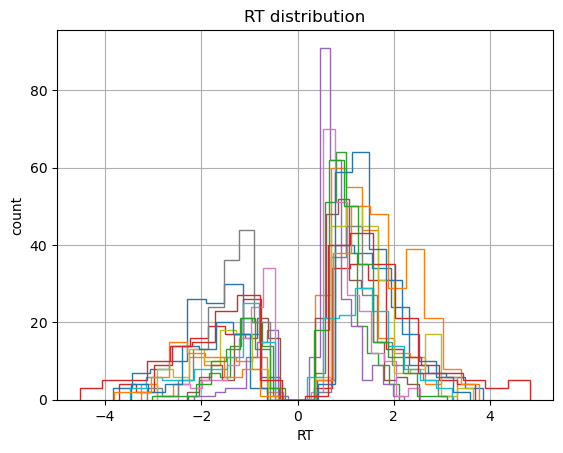

In [17]:
data.columns=['subj_idx','stim','rt','response','conf']
              
data1 = hddm.utils.flip_errors(data)
fig=plt.figure()
ax= fig.add_subplot(111, xlabel="RT",ylabel='count',title='RT distribution' )
for  i,subj_data in data1.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [18]:
print("The number of trials: ", data.shape[0])
print("The number of variables: ", data.shape[1])
print("The number of participants: ", data.subj_idx.unique().shape[0])

The number of trials:  3988
The number of variables:  5
The number of participants:  14


In [22]:
print(data.dtypes)

subj_idx      int64
stim         object
rt          float64
response      int64
conf         object
dtype: object


In [ ]:
# data["Effort"] = data["Effort"].astype(int)  # 0/1 的二分类变量
# data["cXX"] = data["cXX"].astype(float)  # 连续型变量

# Set Model

## Official

In [19]:
df = data.copy()

# Model 0: base model: full model
mm0 = hddm.HDDM(df, include=['a', 'v', 't', 'z'])

# Model 1: treat within-subj as between-subj: full model
mm1 = hddm.HDDM(df, include=['a', 'v', 't','z'], depends_on={'v': 'conf'})

# Model 2: regression model (varying intercept and slope)
mm2 = hddm.HDDMRegressor(
  df, "v ~ 1 + C(conf, Treatment('LC'))", 
  include=['a', 'v', 't', 'z'], 
  group_only_regressors=False, 
  keep_regressor_trace=True)

No model attribute --> setting up standard HDDM
Set model to ddm
No model attribute --> setting up standard HDDM
Set model to ddm
No model attribute --> setting up standard HDDM
Set model to ddm


In [21]:
def run_sampling(
    m,
    n_samples=10000,
    n_burn=5000,
    n_chains=4,
    model_name="m",
    progress_bar=True,
):
    """
    Run Markov Chain Monte Carlo (MCMC) sampling for a given model and parameters.
    This function takes a model parameter `m` and runs MCMC sampling using PyMC2.3.8.
    It returns a arviz InferenceData object containing the posterior samples and post-fit model.
    Parameters
    ----------
    m : object
        The model parameter to be sampled.
    n_samples : int, optional
        The number of posterior samples to generate. Default is 10000.
    n_burn : int, optional
        The number of initial samples to discard. Default is 5000.
    n_chains : int, optional
        The number of MCMC chains to run in parallel. Default is 4.
    model_name : str, optional
        The name of the model to be used in the sampling process. Default is "m".
    progress_bar : boolean, optional
        Default=True. Set False hide sampling progress bar. 
    Returns
    -------
    InferenceData : arviz.InferenceData
        A trace object containing the posterior samples.
    Model: HDDM
        A post-fit HDDM model. 
    """

    m_infdata = m.sample(n_samples,
                         burn=n_burn,
                         chains=n_chains,
                         return_infdata=True,
                         save_name="model_fitted/" + model_name,
                         progress_bar=progress_bar)

    return m, m_infdata

In [ ]:
m0, m0_infdata = run_sampling(m0, model_name="m0")

In [ ]:
m1, m1_infdata = run_sampling(m1, model_name="m1", progress_bar=False)

In [ ]:
m1, m1_infdata = run_sampling(m1, model_name="m1", progress_bar=False)

## Unofficial

In [ ]:
v_reg={'model':'v~C(conf, Treatment('LC'))','link_func':lambda x:x}
reg_des=[v_reg]
m2 = hddm.HDDMRegressor(data,
                        reg_des, 
                        include=['v','a','z','t'],
                       )
m2.find_starting_values()
m2.sample(5000, burn=1000,chains=4,return_infdata=False,save_name='m2')

In [ ]:
# 转移Infdata
m2=hddm.load('m2')
m2_infdata=m2.to_infdata(ppc=True,n_ppc=100)

# Model diagnosis

In [5]:
m0=hddm.load('mm0')
m0_infdata=m0.to_infdata(ppc=True,n_ppc=100)

Start generating posterior prediction...
The time of generating PPC took 18.095 seconds
Start converting to InferenceData...
find the existed save name: $model_fitted/mm0


In [6]:
m1=hddm.load('mm1')
m1_infdata=m1.to_infdata(ppc=True,n_ppc=100)

Start generating posterior prediction...
The time of generating PPC took 18.285 seconds
Start converting to InferenceData...
find the existed save name: $model_fitted/mm1


In [7]:
m2=hddm.load('mm2')
m2_infdata=m2.to_infdata(ppc=True,n_ppc=100)

Start generating posterior prediction...
The time of generating PPC took 27.105 seconds
Start converting to InferenceData...
find the existed save name: $model_fitted/mm2


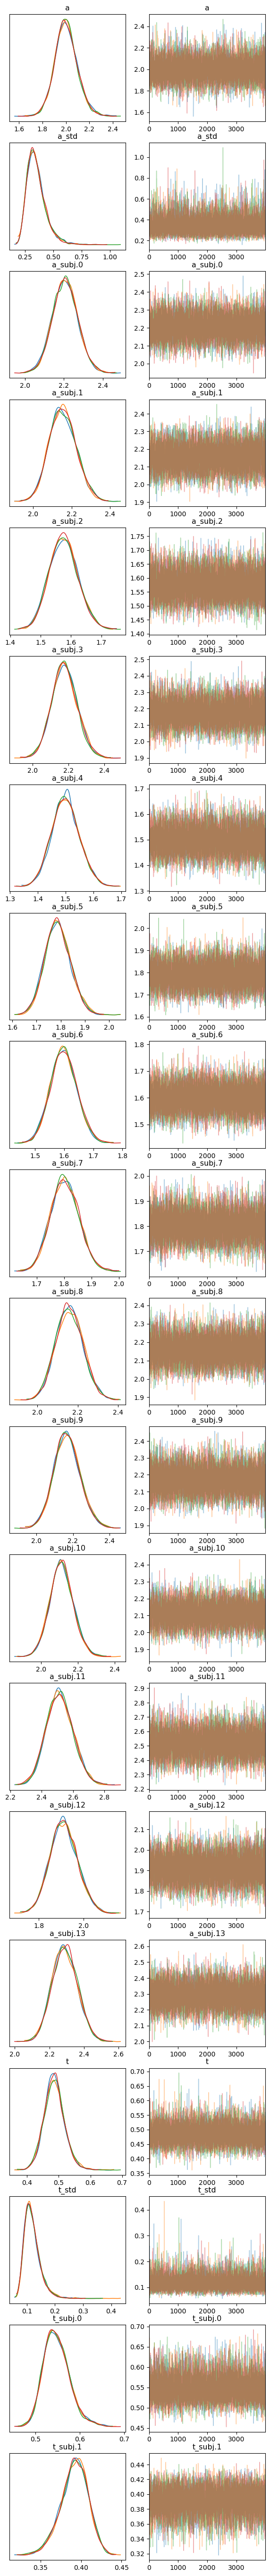

In [9]:
tmp_infdata = m2_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [7, 70])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


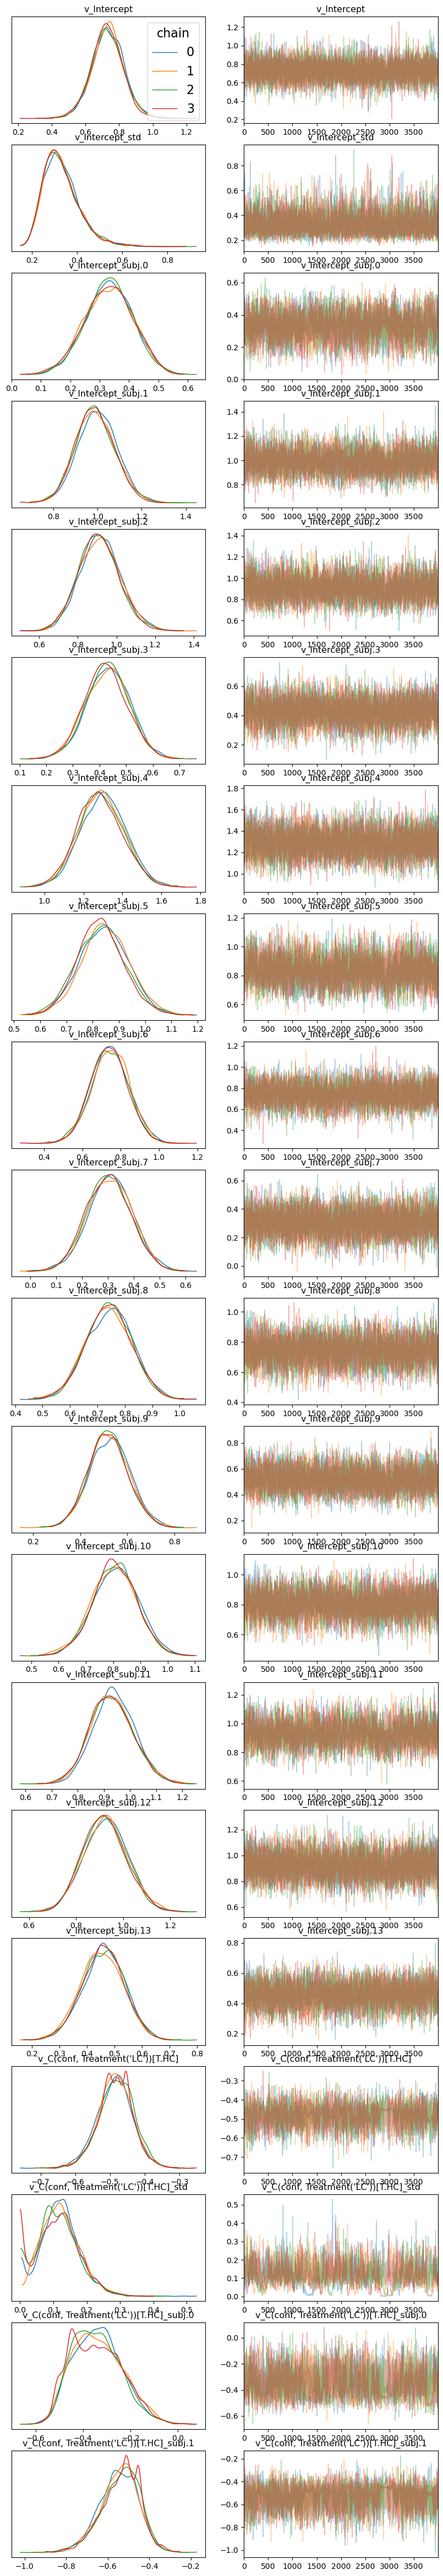

In [10]:
# select population level parameter v as a example
axes = az.plot_trace(
    tmp_infdata, 
    var_names= ('v'), 
    filter_vars='like',
    compact = False, 
    legend=True, 
    figsize = [10, 60]
)

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


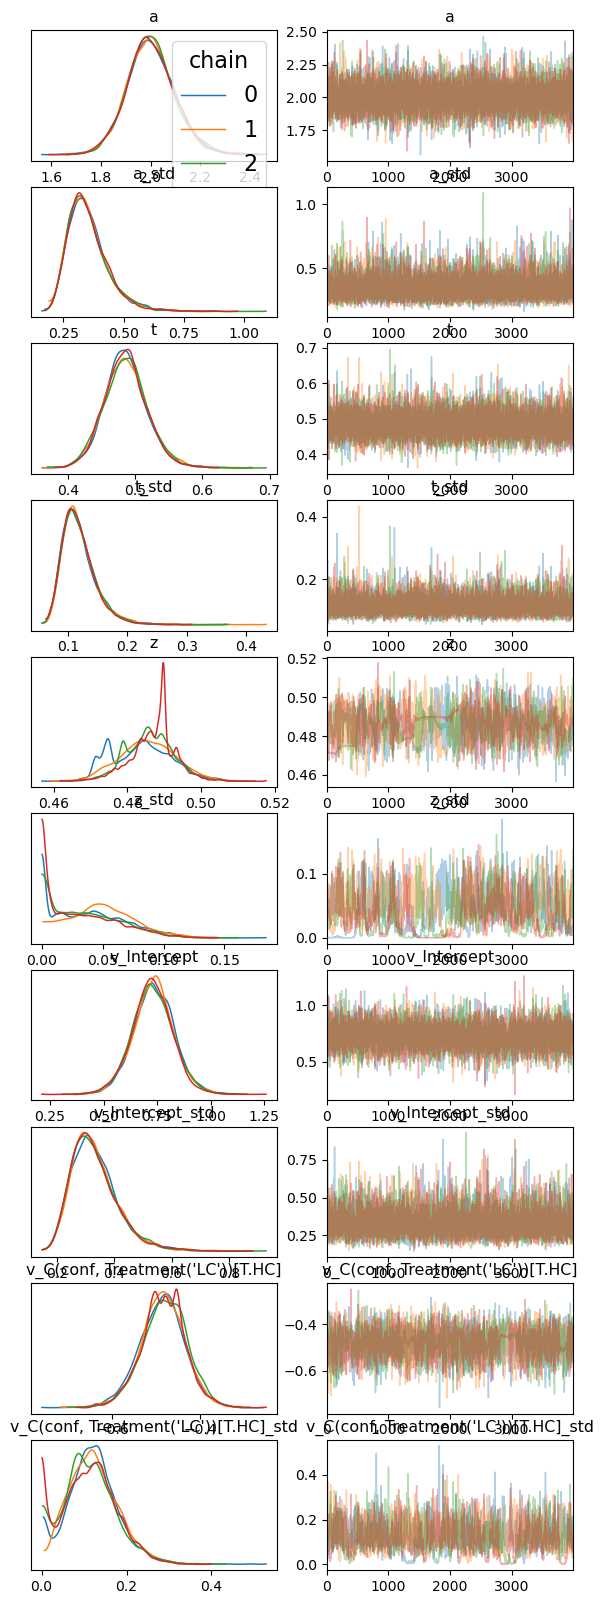

In [11]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [7, 20]
)

In [12]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(30)

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_std,0.0033,0.0024,45.2911,37.4643,1.0630
z_subj.3,0.0008,0.0006,266.7908,353.3775,1.0434
z_subj.13,0.0006,0.0004,342.3942,913.0816,1.0378
z_subj.1,0.0006,0.0004,378.7637,3345.8402,1.0312
z_subj.6,0.0012,0.0008,112.4784,1416.5613,1.0303
z_subj.10,0.0010,0.0007,199.1007,155.8698,1.0275
z_subj.5,0.0010,0.0007,148.6662,2133.9740,1.0259
z,0.0005,0.0003,239.0404,272.9230,1.0239
z_subj.8,0.0005,0.0004,461.6191,4197.2428,1.0206
z_subj.11,0.0005,0.0003,519.1604,3902.4413,1.0199


### $\hat{R}$ < 1.01 and ESS bulk > 400
### 主要使用$\hat{R}$，$\hat{R}$统计量比较链间方差和链内方差

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


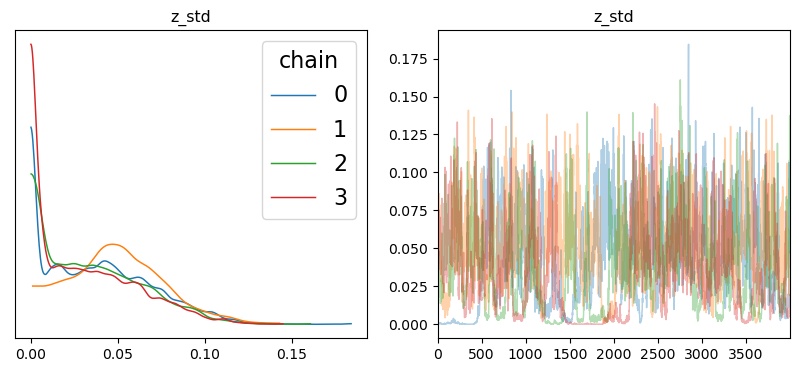

In [13]:
axes = az.plot_trace(
    m2_infdata, 
    var_names=['z_std'], 
    compact = False, 
    legend=True, 
    figsize = [10, 4]
)

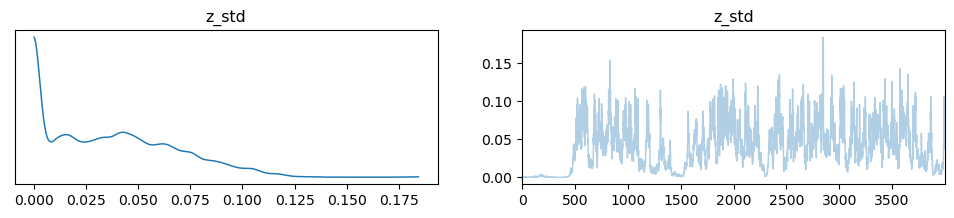

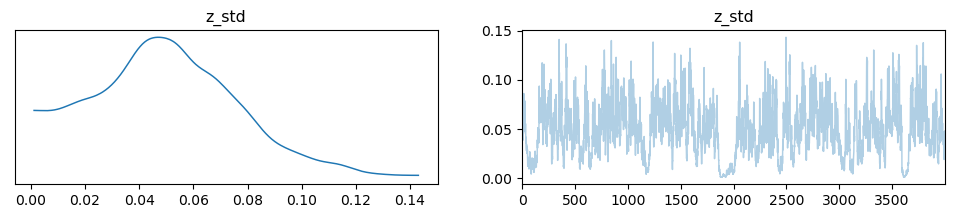

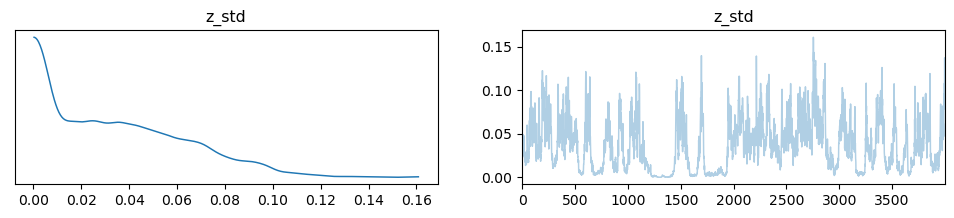

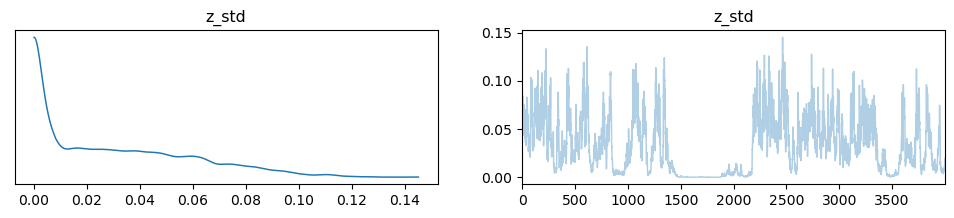

In [14]:
for i in range(4):
    az.plot_trace(
        m2_infdata, 
        var_names=['z_std'], 
        coords = {'chain': [i]}, 
        compact = False, 
        combined = False
    )

# Model comparison and selection

In [15]:
dic_dict = {
  "m0(baseline)":m0.dic,
  "m1(v depends on conf)":m1.dic,
  "m2(reg: v ~ 1 + conf)":m2.dic
}

comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic.sort_values(by=['DIC'], ascending = True)

,model,DIC
m2(reg: v ~ 1 + conf),m2(reg: v ~ 1 + conf),10785.109972
m1(v depends on conf),m1(v depends on conf),10785.970942
m0(baseline),m0(baseline),10969.386620


## Posterior predictive check

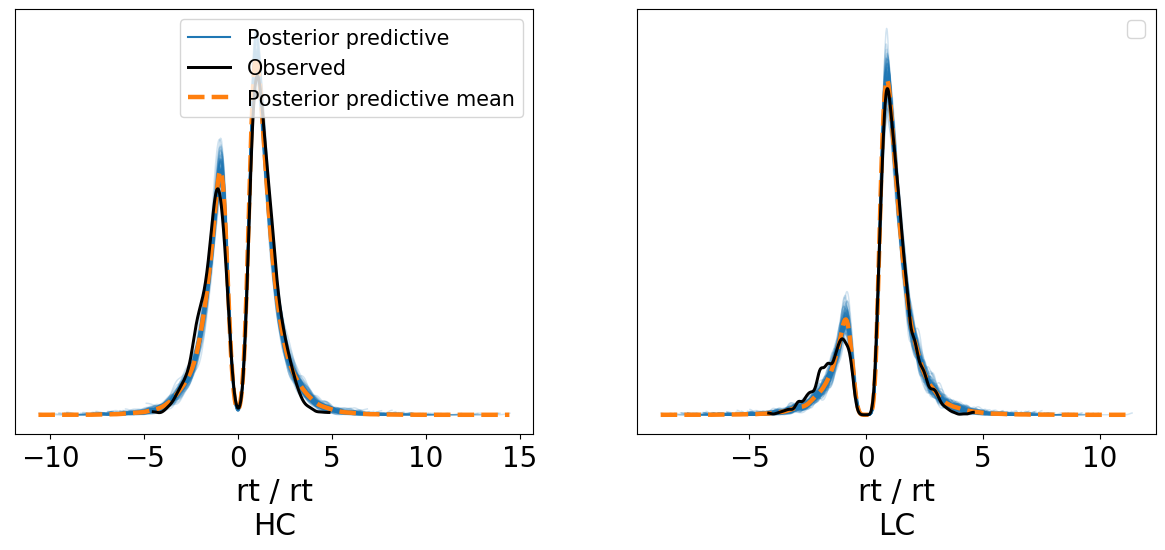

In [16]:
# reset coordinates
m2_infdata = m2_infdata.assign_coords(
  obs_id=m2_infdata.observed_data.variables['conf'].values, 
  groups="observed_vars")


# plot ppc by conditions
axes = az.plot_ppc(
    m2_infdata, 
    var_names= 'rt', 
    coords={'obs_id': ["LC", "HC"]}, 
    num_pp_samples=100, 
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

(-0.9, 0.3)

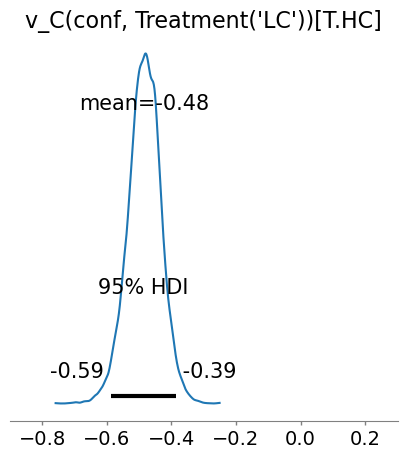

In [17]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
axes = az.plot_posterior(
    m2_infdata,
    var_names=("v_C(conf, Treatment('LC'))[T.HC]"),
    kind = 'hist',
    hdi_prob = 0.95,
    rope = [-0.2, 0.2], # assume this is our ROPE
    textsize=14, 
    rope_color = 'r',
    figsize = (5,5)
)
axes.set_xlim(-0.9,0.3)

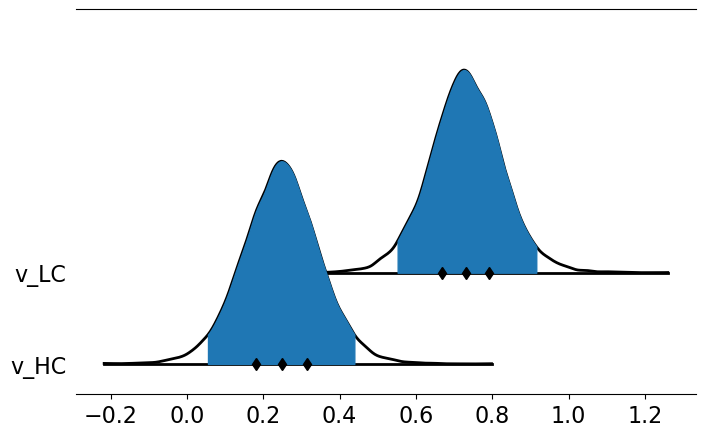

In [22]:
 m2_infdata.posterior["v_HC"] = (
    ("chain", "draw"),
    m2_infdata.posterior["v_Intercept"].values + \
    m2_infdata.posterior["v_C(conf, Treatment('LC'))[T.HC]"].values)
m2_infdata.posterior["v_LC"] = (
    ("chain", "draw"),
    m2_infdata.posterior["v_Intercept"].values)
    # plot posterior forest distriution by conditions
    
axes = az.plot_forest(
    m2_infdata,
    kind='ridgeplot',
    var_names=("v_LC", "v_HC"), 
    linewidth=2,
    ridgeplot_overlap=3,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[.25, .5, .75],
    combined=True,
    figsize=(8, 5)
 )